## All functions with description that are ready to use for backend.

### All imports necessary for functions

In [9]:
from deepface import DeepFace
import uuid
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from gradio_client import Client
import warnings
import difPy
import cv2
from matplotlib import pyplot as plt
import logging
from blur_detection import estimate_blur
from blur_detection import fix_image_size
from blur_detection import pretty_blur_map


## Functions for image saving

In [10]:
import uuid
import cv2
import os

def saveImage(image, mainPath, previewPath, year, month, date, quality_op=70, max_size=250):
    """
    Saves an image to the specified directory with the given parameters.

    Parameters:
    image (PIL.Image.Image): The image to be saved.
    mainPath (str): The path to the main directory where the image will be saved.
    previewPath (str): The path to the preview directory where the resized image will be saved.
    year (int): The year of the image.
    month (int): The month of the image.
    date (int): The date of the image.
    quality_op (int): The quality of the resized image. Defaults to 70.
    max_size (int): The maximum size of the resized image. Defaults to 250.

    Returns:
    None

    This function saves the original image to the main directory with a unique name generated using UUID.
    It also resizes the image while maintaining the aspect ratio and saves the resized image to the preview directory as a WebP file with lower quality.
    The quality of the output image and the minimum resolution can be adjusted using the `quality_op` and `max_size` variables respectively.
    """
    name = uuid.uuid4().hex
    cv2.imwrite(os.path.join(mainPath, str(year), str(month), str(date), name + ".jpg"), image)
    # Calculate the new size while maintaining the aspect ratio
    original_width, original_height = image.size

    aspect_ratio = original_width / original_height

    if original_width < original_height:
        new_width = max_size
        new_height = int(max_size / aspect_ratio)
    else:
        new_height = max_size
        new_width = int(max_size * aspect_ratio)

    # Resize the image
    resized_image = image.resize((new_width, new_height), Image.ANTIALIAS)

    output_path = os.path.join(previewPath, str(year), str(month), str(date), name) + ".webp"

    # Save the resized image as WebP with lower quality
    resized_image.save(output_path, 'WEBP', quality=quality_op) 

    print(f"Image saved to {output_path}")



### Face Recognition
This code defines functions for training a face recognition model using the DeepFace library, recognizing faces in an image, and plotting the recognized faces with rectangles and labels. It then calls these functions to recognize faces in a specific image and plot the results.

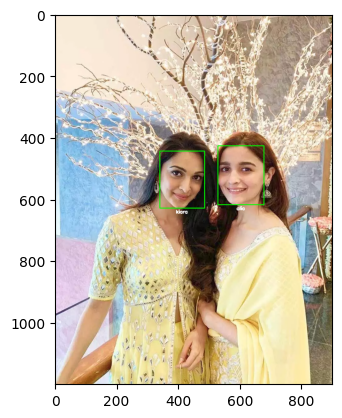

In [11]:
from deepface import DeepFace
import uuid
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def trainModel(path) -> None:
    """
    This function trains the model and saves it to the specified path.
    
    Parameters:
    path (str): The path to the directory where images are kept and the model also will be saved here.

    Returns:
    None
    """
    # Delete previous model
    try:
        os.remove(os.path.join(path,'representations_facenet512.pkl'))
    except:
        pass

    # Train the model
    DeepFace.find(
        img_path = np.zeros((100, 100, 3), dtype=np.uint8),
        db_path = r"C:\Users\meet2\Downloads\imgs2", 
        model_name = "Facenet512",
        enforce_detection=False,
        silent=True,
    )


def cropFaces(image_path,x,y,w,h) -> None:
    """
    Crop a face region from an image and save it.

    Prameters:
    - image_path (str): The path to the image file.
    - x (int): The x-coordinate of the top-left corner of the face region.
    - y (int): The y-coordinate of the top-left corner of the face region.
    - w (int): The width of the face region.
    - h (int): The height of the face region.

    Returns:
    - None: Saves the cropped face region to the same image file.

    This function loads an image from the provided path, crops the specified face region
    based on the given coordinates and dimensions (x, y, w, h), and saves the cropped face
    back to the original image file.
    """
    image = cv2.imread(image_path)
    
    # Crop the detected face
    cropped_face = image[y:y+h, x:x+w]

    # Save the cropped face
    cv2.imwrite(image_path, cropped_face)

 
def recogniseFaces(image_path) -> list:
    """
    This function loads an image from the provided path, detects faces in the image.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    None

    """
    unknownPeople = False
    dfs = DeepFace.find(
        img_path = image_path,
        db_path = r"C:\Users\meet2\Downloads\imgs2", # TODO: Change this to the path where the images are stored
        model_name = "Facenet512",
        enforce_detection=False,
        silent=True,
        detector_backend='retinaface'   # use retina to detect images and save | use opencv(def) to train model from cropped ones efficiency almost similar
    )
    # print(dfs)
    people = []
    # iterate over the list of dataframes
    for df in dfs:
        # check if the dataframe is empty
        if df.empty:
            unknownPeople = True
            continue

        p = {}
        #iterate over the rows of the dataframe
        for index, row in df.iterrows():
            #check if id is already in people list
            if index == 0:
                p['id'] = row["identity"].split("\\")[-1].split("/")[0]
                p['face'] = [row['source_x'],row['source_y'],row['source_w'],row['source_h']]
                p['cosine'] = row['Facenet512_cosine']
            elif p['cosine'] > row['Facenet512_cosine']:
                        p['id'] = row["identity"].split("\\")[-1].split("/")[0]
                        p['face'] = [row['source_x'],row['source_y'],row['source_w'],row['source_h']]
                        p['cosine'] = row['Facenet512_cosine']
        people.append(p)
    
    if unknownPeople:
        faces = DeepFace.extract_faces(
                img_path=image_path,
                detector_backend='retinaface',
                enforce_detection=False,
            )
        for face in faces:
            # check if face is already in people list
            if(list(face['facial_area'].values()) not in [i['face'] for i in people]):
                people.append({'id':str(uuid.uuid4().hex),'face':list(face['facial_area'].values()),'cosine':0.0})
    # print(people)
    return people


def PlotFace(image_path, faces) -> None:
    """
    This function is for testing purposes only.
    It plots the faces with rectangles and labels.

    Parameters:
    None

    Returns:
    None
    """
    # Draw rectangles on the image
    image = cv2.imread(image_path)
    for face in faces:
        x, y, w, h = face['face']
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Green rectangles, 2px thick
        
        # Determine the text to display
        if len(face['id']) != 32:
            text = face['id']
        else:
            text = "Unknown"

        # Calculate the position of the text based on its size
        text_size = cv2.getTextSize(text, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)[0]
        text_x = x + (w - text_size[0]) // 2
        text_y = y + h + text_size[1] + 5  # Adjust this value to set the distance of text from rectangle

        # Display the text
        cv2.putText(image, text, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

    # Display the image with rectangles
    # cv2.imshow('Image with Rectangles', image)
    # cv2.waitKey(0)

    plt.imshow(image[:, :, ::-1])
    plt.show()


faces = recogniseFaces(r"C:\Users\meet2\Downloads\ak.webp")
PlotFace(r"C:\Users\meet2\Downloads\ak.webp", faces)

## Blur image detection
Checks if an image is blurry by calculating the Laplacian variance and counting the number of edges. It then calls this function on a specific image and displays the image along with the result.

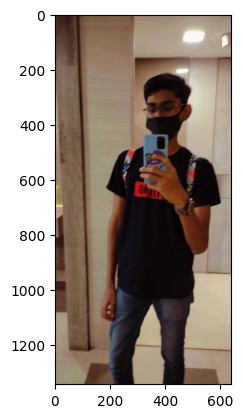

Blur = True


In [12]:
import cv2
from matplotlib import pyplot as plt
import logging
from blur_detection import estimate_blur
from blur_detection import fix_image_size
from blur_detection import pretty_blur_map

# def is_image_blurry(image_path) -> bool:
def checkBlur(image_path, threshold=100.0) -> bool:
    """
    Checks if an image is blurry.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    bool: True if the image is blurry, False otherwise.
    """
    image = cv2.imread(image_path)
    if image is None:
        logging.warning(f'warning! failed to read image from {image_path}; skipping!')
        return False

    image = fix_image_size(image)
    blur_map, score, blurry = estimate_blur(image, threshold=threshold)

    return blurry


result = checkBlur(r"C:\Users\meet2\Downloads\Snapchat-1903276377.jpg")

# display image using OpenCV
# Load the image
image = cv2.imread(r"C:\Users\meet2\Downloads\Snapchat-1903276377.jpg")

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

print(f'Blur = {result}')

## Auto-Image Tagging
This calls an API to predict the content of an image using the Gradio client library. It returns a list of predicted labels for the image. Please note that this process may take some time (approximately 6 seconds minimum), so it is recommended to run the full function on a different thread to avoid blocking the main execution.

Loaded as API: https://xinyu1205-recognize-anything.hf.space/ ✔


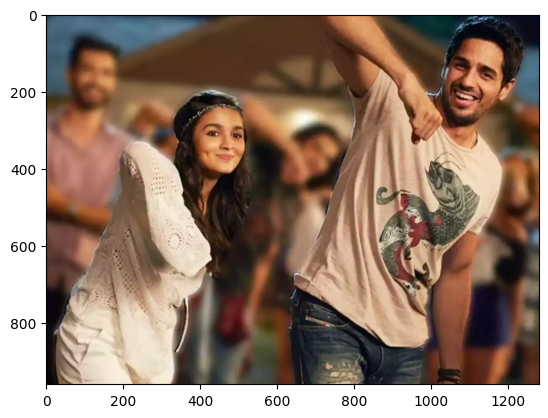

Image tags = ['actor', 'dance', 'girl', 'person', 'laugh', 'man', 'smile', 'woman']


In [13]:
from gradio_client import Client
import warnings
import cv2
import matplotlib.pyplot as plt

def tagImage(image_url) -> list:
    """
    Calls an API to predict the content of an image.

    Parameters:
    image_url (str): The URL of the image.

    Returns:
    list: A list of predicted labels for the image.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        client = Client("https://xinyu1205-recognize-anything.hf.space/")
        result = client.predict(image_url, fn_index=2)
        return result[0].split(" | ")

tags = tagImage(r"C:\Users\meet2\Downloads\98675647.webp")

# display image using OpenCV
# Load the image
image = cv2.imread(r"C:\Users\meet2\Downloads\98675647.webp")

# Display the image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

print(f'Image tags = {tags}')

## Duplicate / Similar Image Detection
The code loads and displays two images using OpenCV and Matplotlib. It then utilizes the difPy library to find and print similar images and their lower quality matches within a specified directory.

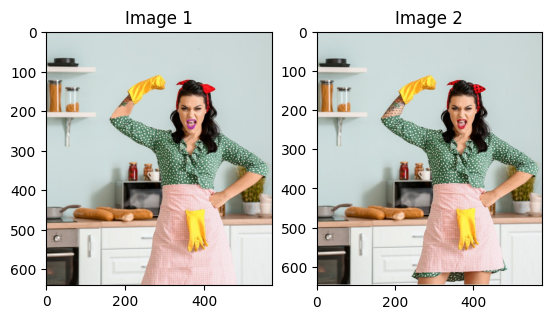

difPy searching files: [100%]
{78608436399356289549372692940216212806: {'location': 'C:\\Users\\meet2\\Downloads\\20231028_204801 (1).jpg', 'matches': {325320397428158181063440989510658521966: {'location': 'C:\\Users\\meet2\\Downloads\\20231028_204801.jpg', 'mse': 0.7564}}}, 51603011226126739295852654197494788650: {'location': 'C:\\Users\\meet2\\Downloads\\263203702-da9f2026-3635-4150-9373-4ac84c1325d0.gif', 'matches': {199370107443257041273211473739237588359: {'location': 'C:\\Users\\meet2\\Downloads\\delete_dark.png', 'mse': 36.674}, 304895456908270318477252742294090607045: {'location': 'C:\\Users\\meet2\\Downloads\\delete_light.png', 'mse': 16.9888}, 113843425118575801834954338604700139602: {'location': 'C:\\Users\\meet2\\Downloads\\edit_dark.png', 'mse': 16.9888}, 51918862545045628258071091389972230008: {'location': 'C:\\Users\\meet2\\Downloads\\edit_light.png', 'mse': 4.2556}, 284376674604455214282749473706811303538: {'location': 'C:\\Users\\meet2\\Downloads\\whatsapp_dark.png', '

In [14]:
import difPy
import cv2
import matplotlib.pyplot as plt

def find_similar_images(directory) -> None:
    """
    Finds similar images in the specified directory using the difPy library.

    Parameters:
    directory (str): The path to the directory containing the images.

    Returns:
    None

    This function builds a difPy index for the images in the specified directory and performs a search for similar images.
    The search results are printed, including the similar images and their lower quality matches.
    """
    dif = difPy.build(directory, recursive=False, show_progress=False, logs=False)
    search = difPy.search(dif, 'similar')
    print(search.result)
    print(search.lower_quality)

# Load the first image
image1 = cv2.imread(r"C:\Users\meet2\Downloads\sim1.jpg")

# Load the second image
image2 = cv2.imread(r"C:\Users\meet2\Downloads\sim2.jpg")

# Create subplots to display images side by side
fig, axes = plt.subplots(1, 2)

# Display the first image
axes[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axes[0].set_title("Image 1")

# Display the second image
axes[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axes[1].set_title("Image 2")

# Show the subplots
plt.show()

# Find similar images in the directory
find_similar_images(r"C:\Users\meet2\Downloads")


## Compress Image / Video
The code compresses image and video files, resizing them if necessary, and saving the compressed files with specified quality and resolution.

Image compressed successfully.


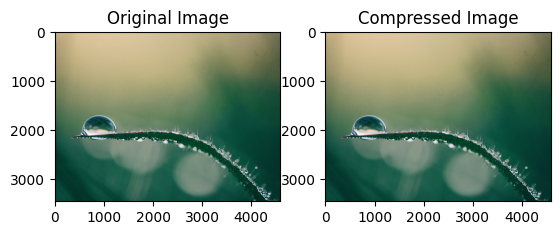

Original Image Size: 3.47 MB
Compressed Image Size: 1.88 MB


In [18]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import cv2
from moviepy.editor import VideoFileClip

def compress_image(input_path, output_path, quality=75):
    """
    Compresses an image file instead of original image.

    Parameters:
        input_path (str): The path to the input image file.
        output_path (str): The desired path for the compressed output image file.
        quality (int): The compression quality, ranging from 1 (lowest) to 95 (highest). Default is 75.

    Returns:
        bool: True if the output image was successfully saved, False otherwise.
    """
    max_resolution=16 * 1024 * 1024  #16 MP

    # Open the input image
    image = Image.open(input_path)

    # Check if the image resolution is greater than the maximum resolution
    if image.size[0] * image.size[1] > max_resolution:
        print("Image resolution greater than max resolution. Image will be resized.")
        # Calculate the new dimensions to resize the image
        aspect_ratio = image.size[0] / image.size[1]
        new_width = int((max_resolution * aspect_ratio) ** 0.5)
        new_height = int(max_resolution / new_width)
        new_size = (new_width, new_height)
        # Resize the image using LANCZOS resampling method
        image = image.resize(new_size, Image.LANCZOS)

    # Compress the image
    image.save(output_path, optimize=True, quality=quality)

    # Check if the output image was successfully saved
    if os.path.exists(output_path):
        return True
    else:
        return False

def compress_video(input_path, output_path):
    """
    Compresses a video file instead of original video.

    Parameters:
        input_path (str): The path to the input video file.
        output_path (str): The desired path for the compressed output video file.

    Returns:
        bool: True if the output video was successfully saved, False otherwise.
    """
    max_resolution = 1920 * 1080  # Maximum resolution for high-definition 1080p

    # Open the input video
    video = VideoFileClip(input_path)

    # Check if the video resolution is greater than the maximum resolution
    if video.size[0] * video.size[1] > max_resolution:
        print("Video resolution greater than max resolution. Video will be resized.")
        # Resize the video to high-definition 1080p
        video = video.resize(height=1080)

    # Compress the video
    video.write_videofile(output_path, codec="libx264", bitrate=f"5000k")

    # Check if the output video was successfully saved
    if os.path.exists(output_path):
        return True
    else:
        return False


# Compress the image
compress = compress_image(r"C:\Users\meet2\Downloads\nb.jpg", r"C:\Users\meet2\Downloads\nb_compressed.jpg", quality=75)
if compress:
    print("Image compressed successfully.")

# Show both images side by side using pyplot
image1 = cv2.imread(r"C:\Users\meet2\Downloads\nb.jpg")
image2 = cv2.imread(r"C:\Users\meet2\Downloads\nb_compressed.jpg")
fig, axes = plt.subplots(1, 2)
axes[0].imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
axes[0].set_title("Original Image")
axes[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axes[1].imshow(cv2.cvtColor(image2, cv2.COLOR_BGR2RGB))
axes[1].set_title("Compressed Image")
plt.show()

# Print the sizes of both images in megabytes (MB)
original_size_mb = os.path.getsize(r"C:\Users\meet2\Downloads\nb.jpg") / (1024 * 1024)
compressed_size_mb = os.path.getsize(r"C:\Users\meet2\Downloads\nb_compressed.jpg") / (1024 * 1024)
print("Original Image Size: {:.2f} MB".format(original_size_mb))
print("Compressed Image Size: {:.2f} MB".format(compressed_size_mb))
